# **Perceiver for image classification**

Using Perceiver architecture to classify CIFAR 10 dataset

In [1]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


Importing necessary libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


Downloading CIFAR-10 dataset from Keras

**Using only a subset of the data (5000 images as opposed to 50000 images as shown in the Keras.io example), as training the model on the entire dataset takes 10+ hours per epoch, as shown in the attached screenshot below -**

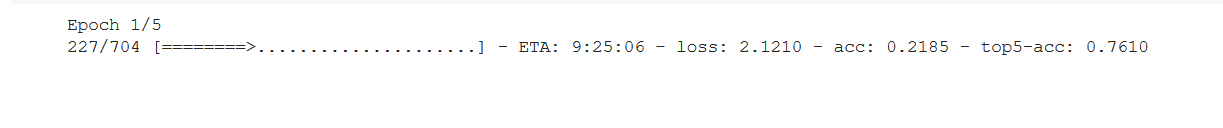

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:500]
y_test = y_test[:500]


print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (5000, 32, 32, 3) - y_train shape: (5000, 1)
x_test shape: (500, 32, 32, 3) - y_test shape: (500, 1)


### Defining the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64 
num_epochs = 5 #reducing the number of epochs to accelerate the training time
dropout_rate = 0.2
image_size = 64  
patch_size = 2  
num_patches = (image_size // patch_size) ** 2  
latent_dim = 256 
projection_dim = 256  
num_heads = 8  
ffn_units = [
    projection_dim,
    projection_dim,
] 
num_transformer_blocks = 4
num_iterations = 2  
classifier_units = [
    projection_dim,
    num_classes,
]  

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")
print(f"Latent array shape: {latent_dim} X {projection_dim}")
print(f"Data array shape: {num_patches} X {projection_dim}")


Image size: 64 X 64 = 4096
Patch size: 2 X 2 = 4 
Patches per image: 1024
Elements per patch (3 channels): 12
Latent array shape: 256 X 256
Data array shape: 1024 X 256


### Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)


### Feed forward network

In [6]:
def create_ffn(hidden_units, dropout_rate):
    ffn_layers = []
    for units in hidden_units[:-1]:
        ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    ffn_layers.append(layers.Dense(units=hidden_units[-1]))
    ffn_layers.append(layers.Dropout(dropout_rate))

    ffn = keras.Sequential(ffn_layers)
    return ffn


### Patch creation as a layer

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


### Patch encoding layer to linearly transform a patch by projecting it to a vector of a lower dimension

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


### Defining the Perceiver model

In [9]:
def create_cross_attention_module(
    latent_dim, data_dim, projection_dim, ffn_units, dropout_rate
):

    inputs = {
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        "data_array": layers.Input(shape=(data_dim, projection_dim)),
    }

    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = layers.Attention(use_scale=True, dropout=0.1)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attention_output = layers.Add()([attention_output, latent_array])

    # Apply layer norm.
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    # Apply Feedforward network.
    ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
    outputs = ffn(attention_output)
    # Skip connection 2.
    outputs = layers.Add()([outputs, attention_output])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [10]:
def create_transformer_module(
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
        x3 = ffn(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=x0)
    return model


In [11]:
class Perceiver(keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.
        self.patcher = Patches(self.patch_size)

        # Create patch encoder.
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super(Perceiver, self).build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patcher(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits


### Training

In [12]:
def run_experiment(model):

    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.LAMB(
        learning_rate=learning_rate, weight_decay_rate=weight_decay,
    )

    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=3
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )

    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


In [ ]:
perceiver_classifier = Perceiver(
    patch_size,
    num_patches,
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
    num_iterations,
    classifier_units,
)


history = run_experiment(perceiver_classifier)

Epoch 1/5
71/71 [==============================] - 5328s 75s/step - loss: 2.2254 - acc: 0.1824 - top5-acc: 0.7131 - val_loss: 2.0640 - val_acc: 0.2340 - val_top5-acc: 0.7640
Epoch 2/5
71/71 [==============================] - 5289s 74s/step - loss: 2.1119 - acc: 0.2138 - top5-acc: 0.7604 - val_loss: 1.9550 - val_acc: 0.2900 - val_top5-acc: 0.8100
Epoch 3/5
71/71 [==============================] - 5195s 73s/step - loss: 2.0597 - acc: 0.2351 - top5-acc: 0.7769 - val_loss: 1.9303 - val_acc: 0.2800 - val_top5-acc: 0.8240
Epoch 4/5
71/71 [==============================] - 5194s 73s/step - loss: 2.0175 - acc: 0.2482 - top5-acc: 0.8004 - val_loss: 1.9066 - val_acc: 0.2420 - val_top5-acc: 0.8220
Epoch 5/5
48/71 [===================>..........] - ETA: 27:26 - loss: 1.9977 - acc: 0.2617 - top5-acc: 0.8070

The colab's runtime disconnected in the last epoch after running for 7+ hours. In the info above, we can see that the train accuracy increased with each epoch and both the training loss and the validation loss decreased with each epoch. The validation accuracy would also increase if the entire dataset is used for training and the model is trained for more iterations